Utilizando esse conjunto de dados:
https://www.kaggle.com/datasets/disham993/9000-movies-dataset

Responda as seguintes perguntas:

In [36]:
import pandas as pd
import numpy as np

# Gerenciamento de experimentos com MLflow
import mlflow

# Download do dataset de filmes do Kaggle
#!kaggle datasets download -d disham993/9000-movies-dataset -p ./movies_dataset

# Descompactar o arquivo baixado
#!unzip -o ./movies_dataset/9000-movies-dataset.zip -d ./movies_dataset

try:
    df = pd.read_csv("./movies_dataset/mymoviedb.csv", engine='python')
    print("O dataset foi importado com sucesso!")

except Exception as e:
    print(f"Ocorreu um erro ao carregar o CSV: {e}")
    print("Verifique se o arquivo 'mymoviedb.csv' existe no diretório './movies_dataset' e não está corrompido.")


O dataset foi importado com sucesso!


1.   Qual tamanho do DataSet?
2.   Quantas linhas?
3.   Quantas colunas?
4.   Qual o tipo de variável de cada coluna?
5.   Qual o filme com maior número de votaçôes?
6.   Qual filme teve a maior nota (critério de desempate é o filme com mais votos)
7.   Existem valores nulos? Se sim, qual tratamento irá realizar? (Se não temos nome de algum filme, melhor nem considerar)
     Sim! Foi necessario converter o Vote_Average e Vote_Count para númerico e forçar a criar o NaN para os dados não númericos ou inválidos. Depois remover os NaN do dataframe.

In [37]:

try:
    # Obter o número de linhas e colunas do DataFrame
    numero_linhas, numero_colunas = df.shape
    print(f"O dataset tem {numero_linhas} linhas")
    print(f"O dataset tem {numero_colunas} colunas.")

    print("\n--- Tipos de variáveis ---")
    print(df.dtypes)


    # Converter a coluna 'vote_count' para numérica, forçando erros a NaN
    df['Vote_Count'] = pd.to_numeric(df['Vote_Count'], errors='coerce')
    df.dropna(subset=['Vote_Count'], inplace=True)

    # Identificar o filme com maior número de votos
    indice_max_votos = df['Vote_Count'].idxmax()
    filme_mais_votado = df.loc[indice_max_votos]
    print("\nFilme com maior número de votos:")
    print(filme_mais_votado[['Title', 'Vote_Count', 'Vote_Average', 'Genre']])


    # Converter a coluna 'vote_average' para numérica, forçando erros a NaN
    df['Vote_Average'] = pd.to_numeric(df['Vote_Average'], errors='coerce')
    df.dropna(subset=['Vote_Average'], inplace=True)

    # Identificar o filme que teve a maior nota (criterio de desempate: filme com mais votos
    # Primeiro ordena por nota média e depois por número de votos, ambos em ordem decrescente
    filme_melhor_nota = df.sort_values(by=['Vote_Average', 'Vote_Count'], ascending=[False, False])
    melhor_filme = filme_melhor_nota.iloc[0]
    print("\nFilme com a maior nota:")
    print(melhor_filme[['Title', 'Vote_Average', 'Vote_Count', 'Genre']])

except Exception as e:
    print(f"Ocorreu um erro durante a análise dos dados: {e}")



O dataset tem 9837 linhas
O dataset tem 9 colunas.

--- Tipos de variáveis ---
Release_Date          object
Title                 object
Overview              object
Popularity           float64
Vote_Count            object
Vote_Average          object
Original_Language     object
Genre                 object
Poster_Url            object
dtype: object

Filme com maior número de votos:
Title                                    Inception
Vote_Count                                 31077.0
Vote_Average                                   8.4
Genre           Action, Science Fiction, Adventure
Name: 380, dtype: object

Filme com a maior nota:
Title           Kung Fu Master Huo Yuanjia
Vote_Average                          10.0
Vote_Count                             1.0
Genre                        Action, Drama
Name: 9401, dtype: object



8.   Transforme as variaveis categóricas de linguagem e genero em númericas (utilize dummy)

In [31]:
try:
    df_processado = df.copy()

    # Remover linhas com valores NaN nas colunas
    df_processado.dropna(subset=['Original_Language'], inplace=True)
    df_processado.dropna(subset=['Genre'], inplace=True)

    # Divide a coluna 'Genre' em múltiplas colunas dummy    
    genre_dummies = df_processado['Genre'].str.get_dummies(sep=',')
    print(f"Criadas {genre_dummies.shape[1]} colunas dummy para 'Genre'.")

    # Divide a coluna 'Original_Language' em múltiplas colunas dummy
    language_dummies = pd.get_dummies(df['Original_Language'], prefix='Lang', drop_first=True)
    print(f"Criadas {language_dummies.shape[1]} colunas dummy para 'Original_Language'.\n")


    # Usamos pd.concat para adicionar as novas colunas dummy.
    df_processado = pd.concat([df_processado, genre_dummies, language_dummies], axis=1)

    # Remover as colunas categóricas originais
    df_processado = df_processado.drop(['Genre', 'Original_Language'], axis=1)

    print("Variáveis categóricas transformadas em numéricas com sucesso.")
    print(f"Dimensões finais do DataFrame: {df_processado.shape}")
    print(f"Colunas numéricas: {len(df_processado.select_dtypes(include=['number']).columns)}")
    print(f"Colunas categóricas: {len(df_processado.select_dtypes(include=['object']).columns)}")

except Exception as e:
    print(f"Ocorreu um erro ao processar: {e}")


Criadas 38 colunas dummy para 'Genre'.
Criadas 42 colunas dummy para 'Original_Language'.

Variáveis categóricas transformadas em numéricas com sucesso.
Dimensões finais do DataFrame: (9826, 87)
Colunas numéricas: 41
Colunas categóricas: 4


9.   Normalize as variaveis numéricas

In [ ]:
from sklearn.preprocessing import StandardScaler

# Seleciona colunas numéricas
num_cols = df_processado.select_dtypes(include=[np.number]).columns.tolist()

# Exclui colunas binarias (dummies 0/1) para não escalá-las
num_to_scale = [c for c in num_cols if df_processado[c].nunique() > 2]

print("Colunas numéricas detectadas:", num_cols)
print("Colunas que serão normalizadas:", num_to_scale)

# Scaler: StandardScaler (z-score) 
scaler = StandardScaler()

# Preencher NaNs (se houver) antes de ajustar o scaler
df_processado[num_to_scale] = df_processado[num_to_scale].fillna(df_processado[num_to_scale].median())

# Ajustar e transformar
df_processado[num_to_scale] = scaler.fit_transform(df_processado[num_to_scale])

print("Normalização aplicada com sucesso.")

for col in num_to_scale:
    print(f"\nValores normalizados para a coluna '{col}':")
    print(df_processado[col].head())
# ...existing code...

Colunas numéricas detectadas: ['Popularity', 'Vote_Count', 'Vote_Average', ' Action', ' Adventure', ' Animation', ' Comedy', ' Crime', ' Documentary', ' Drama', ' Family', ' Fantasy', ' History', ' Horror', ' Music', ' Mystery', ' Romance', ' Science Fiction', ' TV Movie', ' Thriller', ' War', ' Western', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Colunas que serão normalizadas: ['Popularity', 'Vote_Count', 'Vote_Average']
Normalização aplicada com sucesso.

Valores normalizados para a coluna 'Popularity':
0    46.325474
1    34.786462
2    23.676617
3    21.693715
4    17.039795
Name: Popularity, dtype: float64

Valores normalizados para a coluna 'Vote_Count':
0    2.890296
1   -0.092657
2   -0.486733
3    1.410500
4    0.153210
Name: Vote_Count, dtype: float64

Valores normalizados para a coluna 'Vote_Average':
0    

10.  Armazene esses valores como um artefato dentro do MLFlow

In [23]:
import joblib
import os
import shutil

# Criar diretório temporário para artefatos
os.makedirs("temp_artifacts", exist_ok=True)

# Salvar DataFrame processado
df_processado.to_csv("temp_artifacts/dados_normalizados.csv", index=False)
joblib.dump(scaler, "temp_artifacts/scaler.pkl")

# Iniciar experimento MLflow com métricas expandidas
with mlflow.start_run(run_name="processamento_dados"):
    # Parâmetros do dataset
    mlflow.log_param("num_amostras_original", len(df))
    mlflow.log_param("num_amostras_processado", len(df_processado))
    mlflow.log_param("num_features_total", df_processado.shape[1])
    mlflow.log_param("num_features_numericas", len(num_to_scale))
    mlflow.log_param("num_generos_unicos", genre_dummies.shape[1])
    mlflow.log_param("num_idiomas_unicos", language_dummies.shape[1])

    # Métricas estatísticas das principais variáveis
    for col in num_to_scale:
        mlflow.log_metric(f"media_{col}", df_processado[col].mean())
        mlflow.log_metric(f"mediana_{col}", df_processado[col].median())
        mlflow.log_metric(f"std_{col}", df_processado[col].std())
        
    # Informações sobre dados faltantes
    mlflow.log_metric("porcentagem_dados_completos", 
                      (len(df_processado) / len(df)) * 100)

    # Top gêneros e idiomas
    top_genres = genre_dummies.sum().sort_values(ascending=False)[:5]
    for genre, count in top_genres.items():
        mlflow.log_metric(f"top_genre_{genre}", count)

    # Artefatos
    mlflow.log_artifact("temp_artifacts/dados_normalizados.csv", 
                       artifact_path="dados")
    mlflow.log_artifact("temp_artifacts/scaler.pkl", 
                       artifact_path="preprocessamento")

print("Artefatos e métricas expandidas salvos com sucesso no MLflow!")

# Limpar arquivos temporários
shutil.rmtree("temp_artifacts")

Artefatos e métricas expandidas salvos com sucesso no MLflow!


11. QUais insights é possivel obter desses dados?

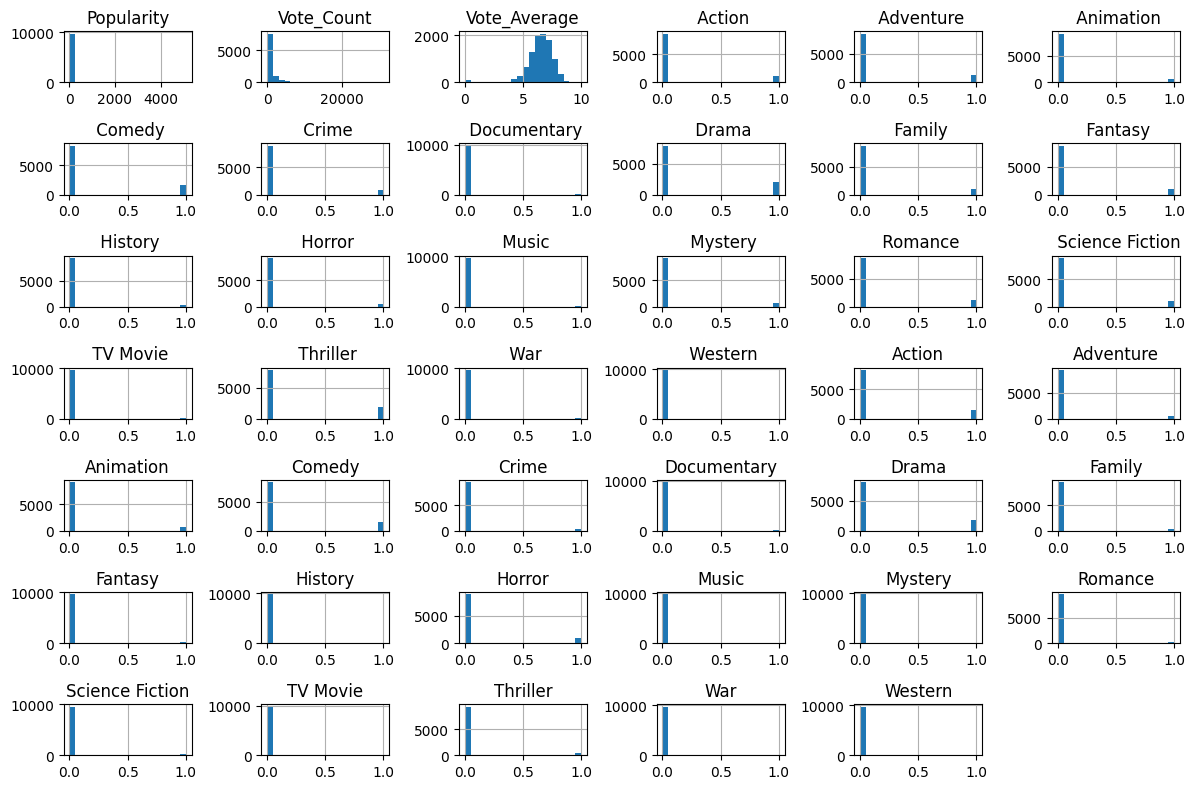

Top 5 Filmes Mais Votados:
               Title  Vote_Count  Vote_Average
380        Inception     31077.0           8.4
461     Interstellar     27975.0           8.4
221  The Dark Knight     26994.0           8.5
138     The Avengers     26490.0           7.7
195         Deadpool     26390.0           7.6

Top 5 Filmes Melhor Avaliados:
                                              Title  Vote_Average  Vote_Count
9401                     Kung Fu Master Huo Yuanjia          10.0         1.0
7349              Franco Escamilla: Por La Anécdota           9.2        92.0
667   Demon Slayer: Kimetsu no Yaiba Sibling's Bond           9.1        27.0
2335                              Impossible Things           9.1        82.0
2401          The Three Deaths of Marisela Escobedo           9.0       183.0


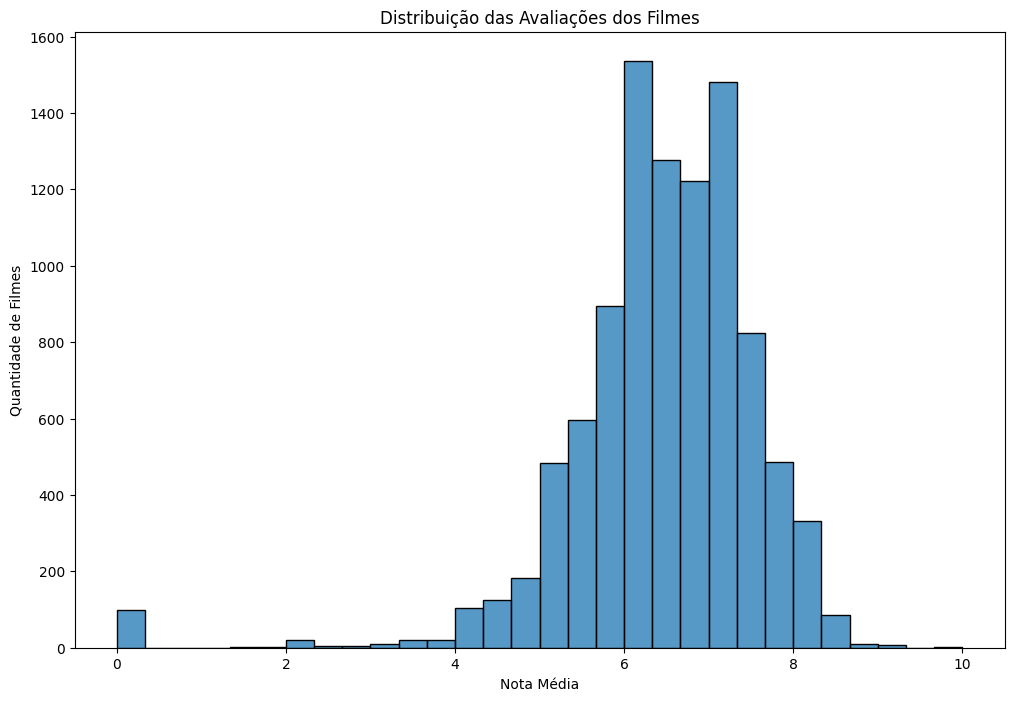

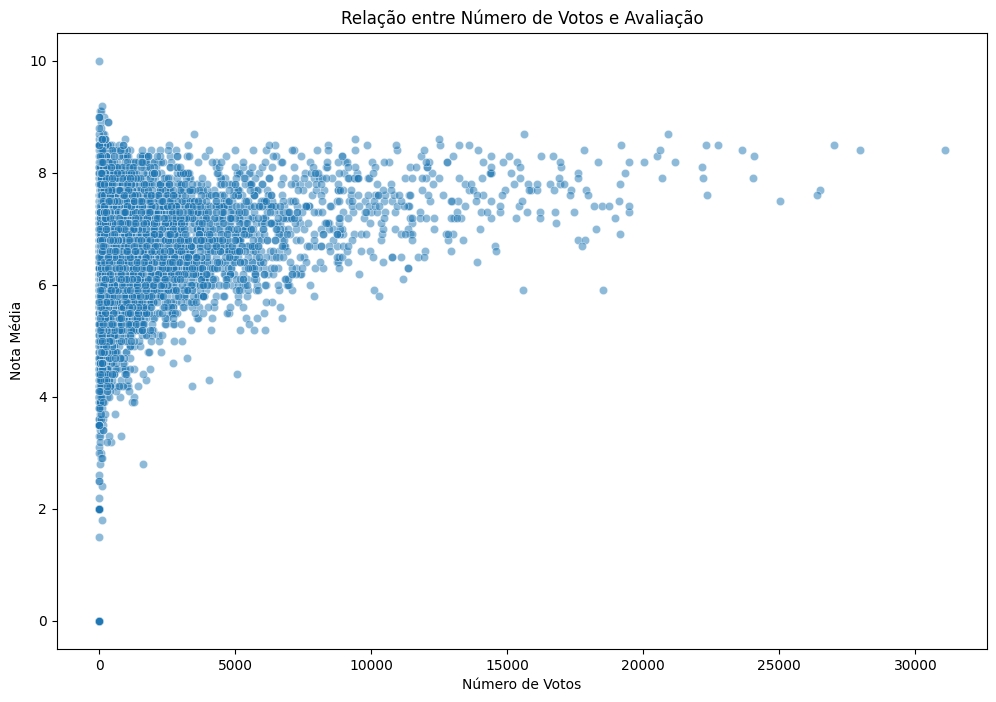


Correlação entre número de votos e avaliação: 0.25


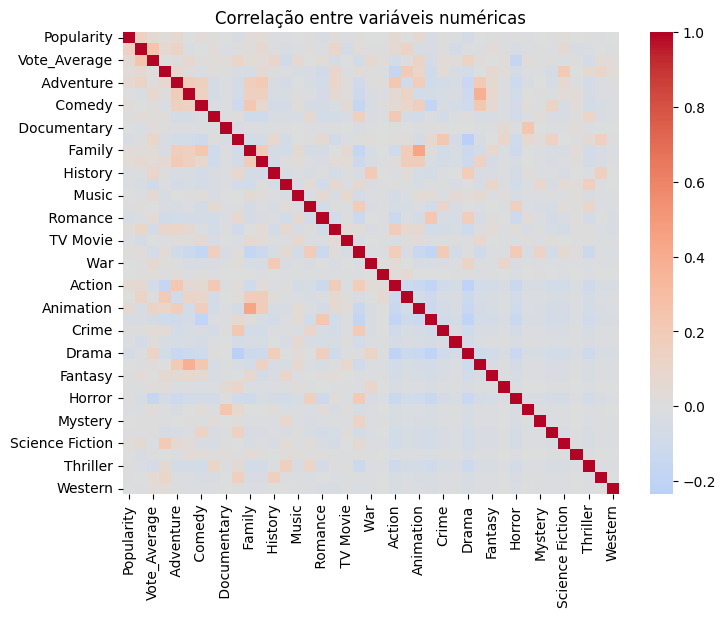

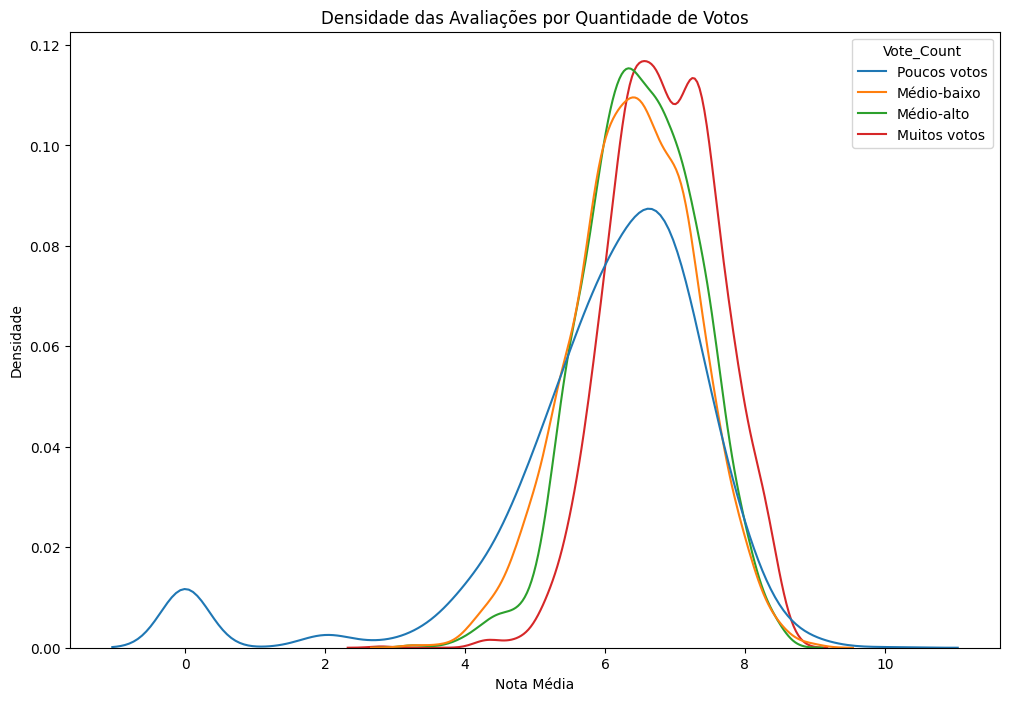


Estatísticas por Idioma:
    total_filmes  media_votos  media_avaliacao  total_votos
en        7569.0  1687.513014         6.370643   12772786.0
ja         645.0   325.435659         6.979225     209906.0
fr         292.0   667.969178         6.314726     195047.0
es         339.0   332.808260         6.576106     112822.0
it         123.0   698.764228         6.529268      85948.0
ko         170.0   464.629412         6.780588      78987.0
de          82.0   532.231707         6.729268      43643.0
cn         109.0   314.422018         6.536697      34272.0
zh         129.0   228.162791         6.736434      29433.0
ru          83.0   244.216867         6.855422      20270.0


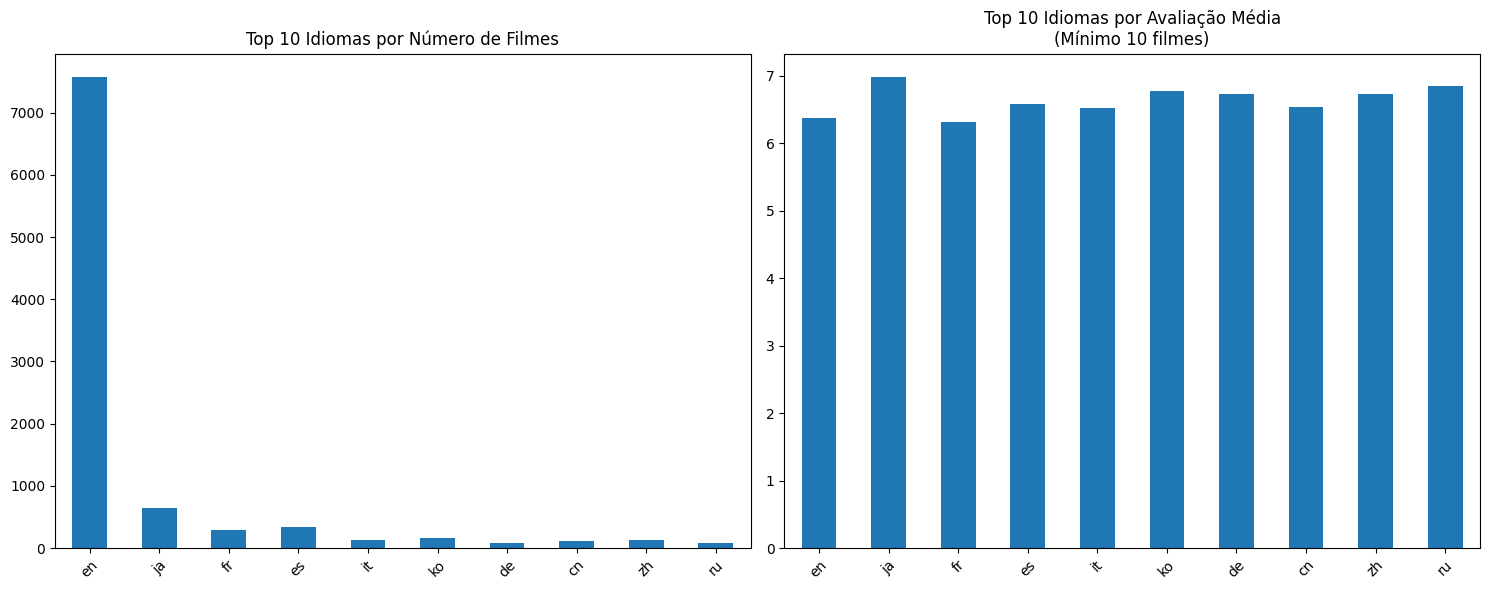


Estatísticas por Gênero:
             count  avg_rating  total_votes
 Thriller   1973.0    6.277547    3055505.0
 Drama      1953.0    6.675371    2810218.0
Drama       1791.0    6.739698    2331277.0
Action      1570.0    6.264013    2791619.0
 Comedy     1547.0    6.476794    2160189.0
Comedy      1484.0    6.285175    1773308.0
 Adventure  1267.0    6.449329    2772927.0
 Romance    1172.0    6.580034    1478448.0
 Action     1116.0    6.423477    2077056.0
 Family     1064.0    6.576034    1629548.0


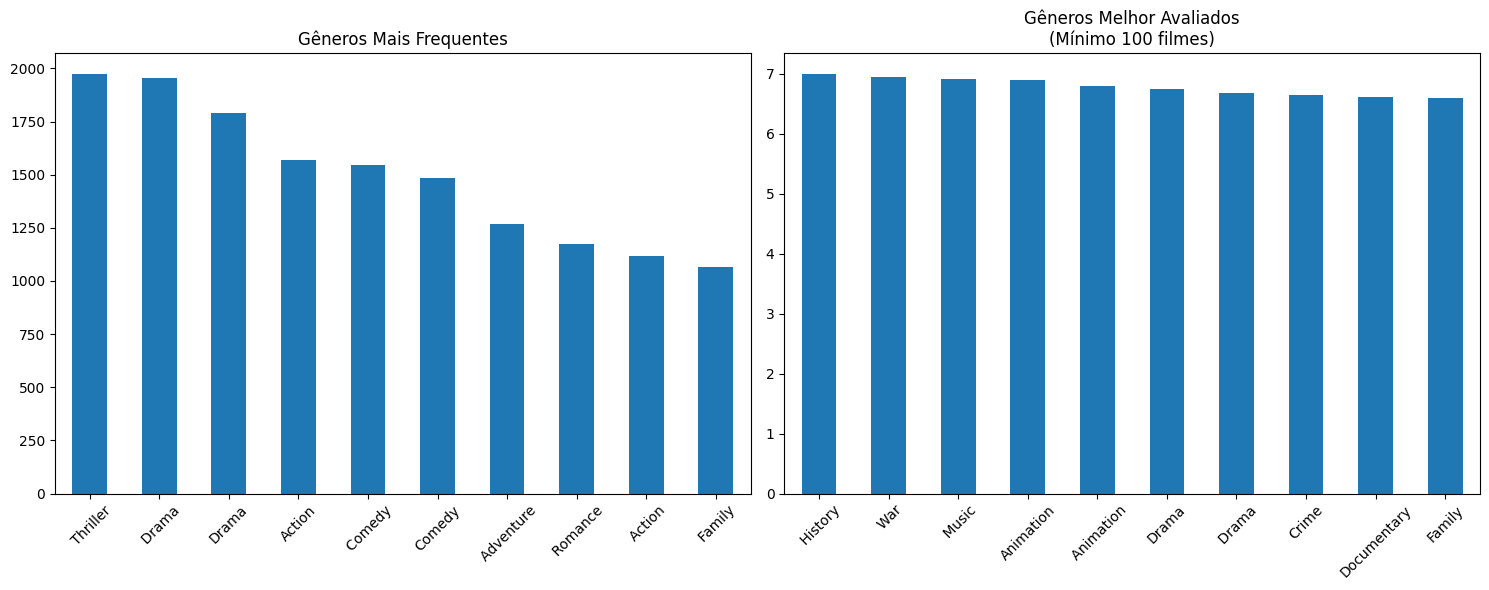

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração para visualização
plt.rcParams['figure.figsize'] = (12, 8)

# Seleciona colunas numéricas
num_cols = df_processado.select_dtypes(include=[np.number]).columns.tolist()

# Histograma das colunas numéricas
if num_cols:
    df_processado[num_cols].hist(figsize=(12, 8), bins=20)
    plt.tight_layout()
    plt.show()

# Filme mais votado e melhor avaliado
top_votes = df_processado.nlargest(5, 'Vote_Count')[['Title', 'Vote_Count', 'Vote_Average']]
top_rated = df_processado.nlargest(5, 'Vote_Average')[['Title', 'Vote_Average', 'Vote_Count']]

print("Top 5 Filmes Mais Votados:")
print(top_votes)
print("\nTop 5 Filmes Melhor Avaliados:")
print(top_rated)

# Distribuição das avaliações
plt.figure()
sns.histplot(data=df_processado, x='Vote_Average', bins=30)
plt.title('Distribuição das Avaliações dos Filmes')
plt.xlabel('Nota Média')
plt.ylabel('Quantidade de Filmes')
plt.show()

# Relação entre votos e avaliações
plt.figure()
sns.scatterplot(data=df_processado, x='Vote_Count', y='Vote_Average', alpha=0.5)
plt.title('Relação entre Número de Votos e Avaliação')
plt.xlabel('Número de Votos')
plt.ylabel('Nota Média')
plt.show()

# Correlação entre votos e avaliações
correlation = df_processado['Vote_Count'].corr(df_processado['Vote_Average'])
print(f"\nCorrelação entre número de votos e avaliação: {correlation:.2f}")
# Mapa de correlação (apenas colunas numéricas)
if len(num_cols) >= 2:
    plt.figure(figsize=(8,6))
    corr = df_processado[num_cols].corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlação entre variáveis numéricas')
    plt.show()


# Densidade das avaliações por número de votos (com log para melhor visualização)
plt.figure()
sns.kdeplot(data=df_processado, x='Vote_Average', hue=pd.qcut(df_processado['Vote_Count'], 
            q=4, labels=['Poucos votos', 'Médio-baixo', 'Médio-alto', 'Muitos votos']))
plt.title('Densidade das Avaliações por Quantidade de Votos')
plt.xlabel('Nota Média')
plt.ylabel('Densidade')
plt.show()



# Diversidade Cultural
def analise_diversidade_cultural():
    # Identificar colunas de idioma (que começam com 'Lang_')
    lang_cols = [col for col in df_processado.columns if col.startswith('Lang_')]
    
    # Criar DataFrame para estatísticas de idioma
    lang_stats = pd.DataFrame()
    
    for lang in lang_cols:
        # Filmes deste idioma
        lang_movies = df_processado[df_processado[lang] == 1]
        
        # Nome do idioma (removendo o prefixo 'Lang_')
        idioma = lang.replace('Lang_', '')
        
        # Calcular estatísticas
        lang_stats.loc[idioma, 'total_filmes'] = len(lang_movies)
        lang_stats.loc[idioma, 'media_votos'] = lang_movies['Vote_Count'].mean()
        lang_stats.loc[idioma, 'media_avaliacao'] = lang_movies['Vote_Average'].mean()
        lang_stats.loc[idioma, 'total_votos'] = lang_movies['Vote_Count'].sum()
    
    # Ordenar por total de votos
    lang_stats = lang_stats.sort_values('total_votos', ascending=False)
    
    print("\nEstatísticas por Idioma:")
    print(lang_stats.head(10))
    
    # Visualizações
    plt.figure(figsize=(15, 6))
    
    # Top 10 idiomas por número de filmes
    plt.subplot(1, 2, 1)
    lang_stats['total_filmes'].head(10).plot(kind='bar')
    plt.title('Top 10 Idiomas por Número de Filmes')
    plt.xticks(rotation=45)
    
    # Top 10 idiomas por média de avaliação (mínimo 10 filmes)
    plt.subplot(1, 2, 2)
    lang_stats[lang_stats['total_filmes'] >= 10]['media_avaliacao'].head(10).plot(kind='bar')
    plt.title('Top 10 Idiomas por Avaliação Média\n(Mínimo 10 filmes)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Tendências de Gênero
def analise_generos():
    # Média de avaliação por gênero
    genre_stats = pd.DataFrame()
    
    for genre in genre_dummies.columns:
        # Filmes deste gênero
        genre_movies = df_processado[genre_dummies[genre] == 1]
        
        genre_stats.loc[genre, 'count'] = len(genre_movies)
        genre_stats.loc[genre, 'avg_rating'] = genre_movies['Vote_Average'].mean()
        genre_stats.loc[genre, 'total_votes'] = genre_movies['Vote_Count'].sum()
    
    genre_stats = genre_stats.sort_values('count', ascending=False)
    
    print("\nEstatísticas por Gênero:")
    print(genre_stats.head(10))
    
    # Visualização
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gêneros mais frequentes
    genre_stats['count'].head(10).plot(kind='bar', ax=ax1)
    ax1.set_title('Gêneros Mais Frequentes')
    ax1.tick_params(axis='x', rotation=45)
    
    # Gêneros melhor avaliados (mínimo de 100 filmes)
    popular_genres = genre_stats[genre_stats['count'] >= 100]
    popular_genres['avg_rating'].sort_values(ascending=False).head(10).plot(kind='bar', ax=ax2)
    ax2.set_title('Gêneros Melhor Avaliados\n(Mínimo 100 filmes)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


# Executar análises
analise_diversidade_cultural()
analise_generos()

